In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import cross_val_score

In [2]:
# Read in data

insurance = pd.read_csv('insurance.csv')
insurance

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [3]:
# Exploratory Data Analysis

df = insurance.copy()
df = sm.add_constant(df)

scaler = StandardScaler()
numerical_cols = ['age', 'bmi', 'children', 'charges']
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])
df = pd.get_dummies(df).astype(float)

X = df.drop('charges', axis=1)
y = df['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
# Baseline Model

baseline_pred = np.mean(y_train)

print(f"Mean Charge (standardized): {baseline_pred}")

baseline_array = np.full(len(y_test), baseline_pred)

baseline_mae = mean_absolute_error(y_test, baseline_array)
baseline_mse = mean_squared_error(y_test, baseline_array)
baseline_osr2 = r2_score(y_test, baseline_array)

print(f"Linear Regression Mean Squared Error: {baseline_mse:.2f}")
print(f"Linear Regression OSR² Score: {baseline_osr2:.2f}")
print(f"Linear Regression Mean Absolute Error: {baseline_mae:.2f}")

Mean Charge (standardized): 0.006250676563226175
Linear Regression Mean Squared Error: 1.06
Linear Regression OSR² Score: -0.00
Linear Regression Mean Absolute Error: 0.79


In [5]:
# Linear Regression With All Features

linear_model_all = sm.OLS(y_train, X_train).fit()

print(linear_model_all.summary())

linear_all_y_pred = linear_model_all.predict(X_test)
linear_all_mse = mean_squared_error(y_test, linear_all_y_pred)
linear_all_osr2 = r2_score(y_test, linear_all_y_pred)
linear_all_mae = mean_absolute_error(y_test, linear_all_y_pred)

print()
print(f"Linear Regression Mean Squared Error: {linear_all_mse:.2f}")
print(f"Linear Regression OSR² Score: {linear_all_osr2:.2f}")
print(f"Linear Regression Mean Absolute Error: {linear_all_mae:.2f}")

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.739
Method:                 Least Squares   F-statistic:                     338.1
Date:                Sat, 14 Dec 2024   Prob (F-statistic):          3.02e-304
Time:                        05:49:03   Log-Likelihood:                -786.02
No. Observations:                1070   AIC:                             1592.
Df Residuals:                    1060   BIC:                             1642.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const            -2.902e+11   8.09e+11  

In [6]:
# Linear Regression With Feature Selection

X_train_select = X_train[['age', 'bmi', 'children']]
X_test_select = X_test[['age', 'bmi', 'children']]

linear_model_select = sm.OLS(y_train, X_train_select).fit()

print(linear_model_select.summary())

linear_select_y_pred = linear_model_select.predict(X_test_select)
linear_select_mse = mean_squared_error(y_test, linear_select_y_pred)
linear_select_osr2 = r2_score(y_test, linear_select_y_pred)
linear_select_mae = mean_absolute_error(y_test, linear_select_y_pred)

print()
print(f"Linear Regression Feature Selection Mean Squared Error: {linear_select_mse:.2f}")
print(f"Linear Regression Feature Selection OSR² Score: {linear_select_osr2:.2f}")
print(f"Linear Regression Feature Selection Mean Absolute Error: {linear_select_mae:.2f}")

                                 OLS Regression Results                                
Dep. Variable:                charges   R-squared (uncentered):                   0.110
Model:                            OLS   Adj. R-squared (uncentered):              0.107
Method:                 Least Squares   F-statistic:                              43.90
Date:                Sat, 14 Dec 2024   Prob (F-statistic):                    9.37e-27
Time:                        05:49:03   Log-Likelihood:                         -1447.9
No. Observations:                1070   AIC:                                      2902.
Df Residuals:                    1067   BIC:                                      2917.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

CART Mean Squared Error: 0.16
CART Mean Absolute Error: 0.24
CART OSR² Score: 0.85


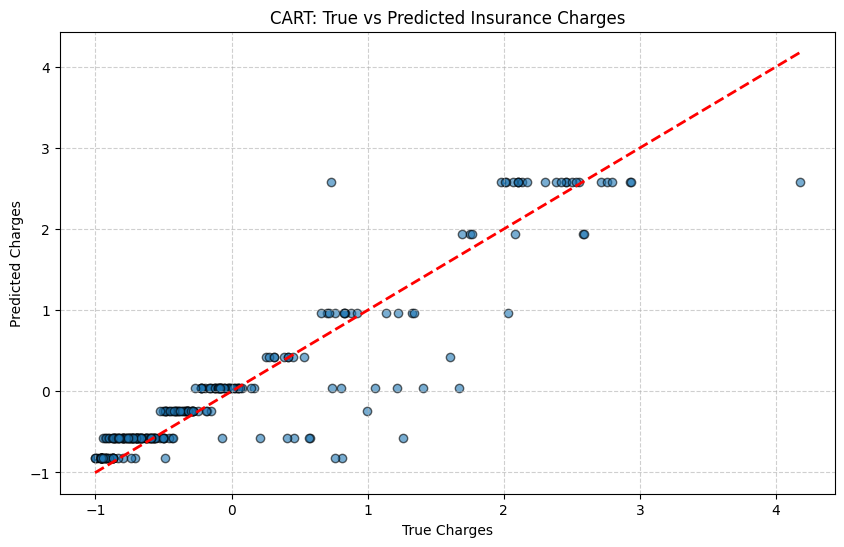

In [14]:
# CART model building and cross validation

clf = DecisionTreeRegressor(random_state=42)

path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(X_train, y_train)
    clfs.append(clf)

cv_scores = [cross_val_score(clf, X_train, y_train, cv=5).mean() for clf in clfs]

best_alpha_idx = np.argmax(cv_scores)
best_alpha = ccp_alphas[best_alpha_idx]

# Build best model
cart_model = DecisionTreeRegressor(random_state=42, ccp_alpha=best_alpha)
cart_model.fit(X_train, y_train)

# Evaluate on the test set
cart_y_pred = cart_model.predict(X_test)

cart_mae = mean_absolute_error(y_test, cart_y_pred)
cart_mse = mean_squared_error(y_test, cart_y_pred)
cart_osr2 = r2_score(y_test, cart_y_pred)

print(f"CART Mean Squared Error: {cart_mse:.2f}")
print(f"CART Mean Absolute Error: {cart_mae:.2f}")
print(f"CART OSR² Score: {cart_osr2:.2f}")

# Plot True vs Predicted for CART
plt.figure(figsize=(10, 6))
plt.scatter(y_test, cart_y_pred, alpha=0.6, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("CART: True vs Predicted Insurance Charges")
plt.xlabel("True Charges")
plt.ylabel("Predicted Charges")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

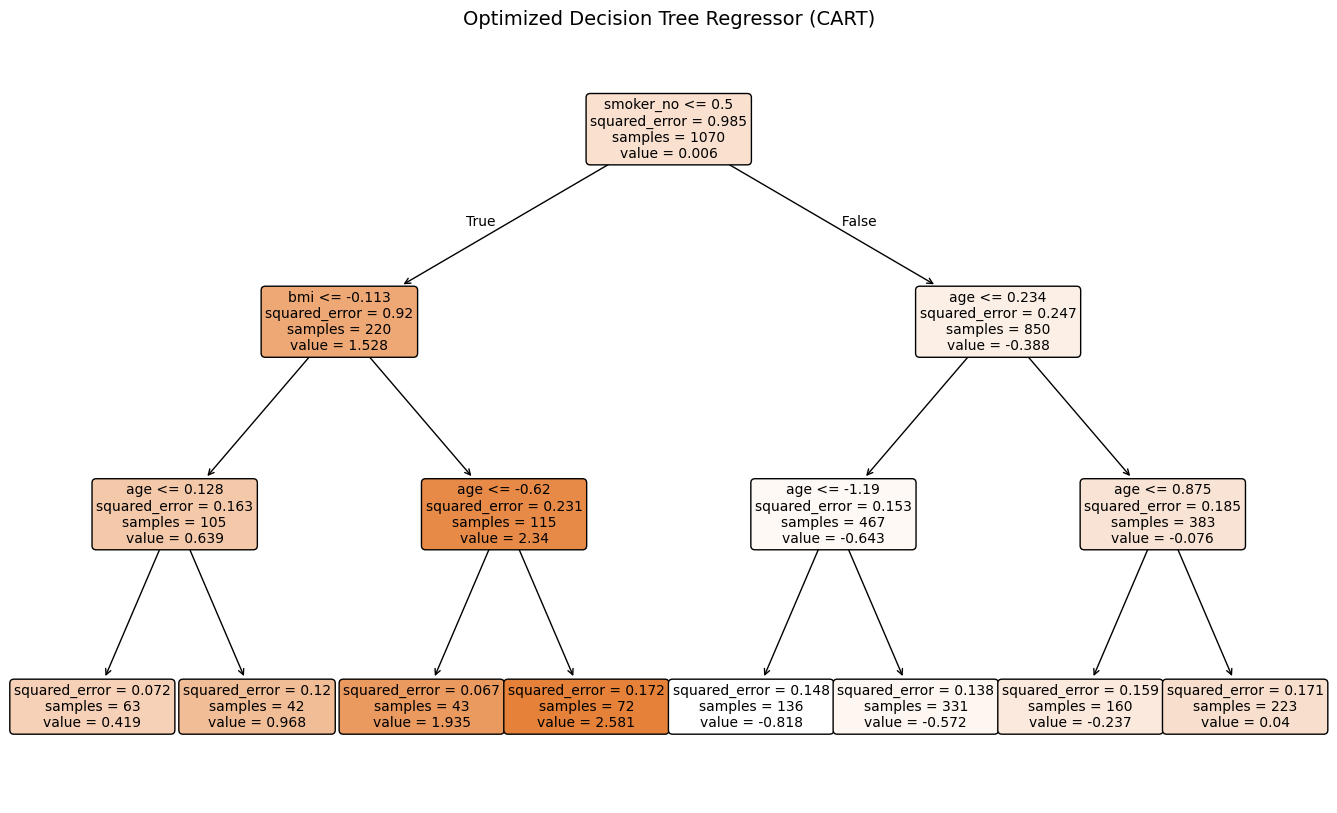

In [15]:
plt.figure(figsize=(17, 10))
plot_tree(
    cart_model,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    fontsize=10,
    max_depth=3  # Limit depth for better visualization
)
plt.title("Optimized Decision Tree Regressor (CART)", fontsize=14)
plt.show()

In [19]:
# Random Forest

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

rf_y_pred = rf_model.predict(X_test)

rf_r2 = r2_score(y_test, rf_y_pred)
rf_mse = mean_squared_error(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)

print(f"Random Forest Mean Squared Error: {rf_mse:.2f}")
print(f"Random Forest OSR² Score: {rf_r2:.2f}")
print(f"Random Forest Mean Absolute Error: {rf_mae:.2f}")

Random Forest Mean Squared Error: 0.15
Random Forest OSR² Score: 0.86
Random Forest Mean Absolute Error: 0.21


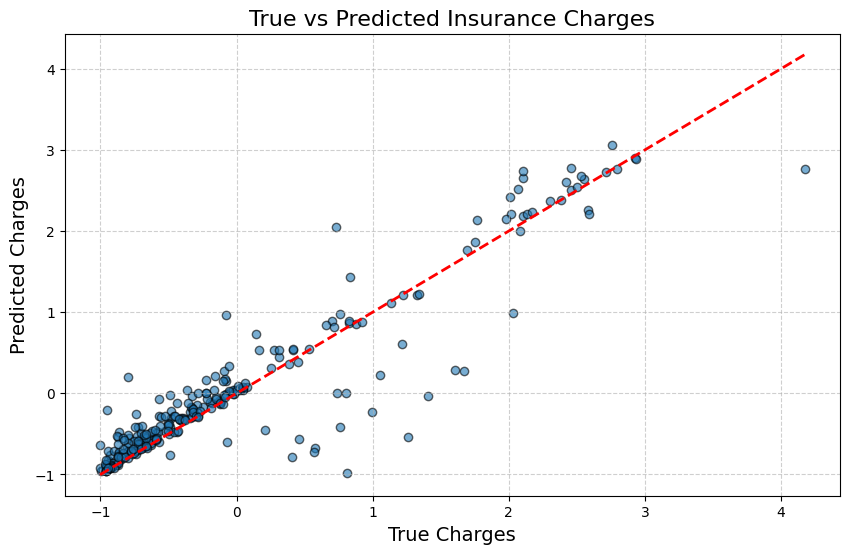

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, rf_y_pred, alpha=0.6, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("True vs Predicted Insurance Charges", fontsize=16)
plt.xlabel("True Charges", fontsize=14)
plt.ylabel("Predicted Charges", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [20]:
# these features have strongest impact on model predictions using threshold of > 0.01

feature_importances = rf_model.feature_importances_
ranking = pd.DataFrame(data=feature_importances, index=X.columns, columns=['Importance'])
ranking = ranking[ranking['Importance'] > 0.01].sort_values(by='Importance', ascending=False)

print(ranking)

            Importance
smoker_yes    0.328406
smoker_no     0.280213
bmi           0.212681
age           0.134473
children      0.019444


In [25]:
new_features = ['smoker_no', 'bmi', 'age', 'children']
X_train_new = X_train[new_features]
X_test_new = X_test[new_features]

rf_nmodel = RandomForestRegressor(random_state=42)
rf_nmodel.fit(X_train_new, y_train)

y_npred = rf_nmodel.predict(X_test_new)

rf_selected_osr2 = r2_score(y_test, y_npred)
rf_selected_mse = mean_squared_error(y_test, y_npred)
rf_selected_mae = mean_absolute_error(y_test, y_npred)

print(f"Random Forest Feature Selection Mean Squared Error: {rf_selected_mse:.2f}")
print(f"Random Forest Feature Selection OSR² Score: {rf_selected_osr2:.2f}")
print(f"Random Forest Feature Selection Mean Absolute Error: {rf_selected_mae:.2f}")

Random Forest Feature Selection Mean Squared Error: 0.15
Random Forest Feature Selection OSR² Score: 0.86
Random Forest Feature Selection Mean Absolute Error: 0.21


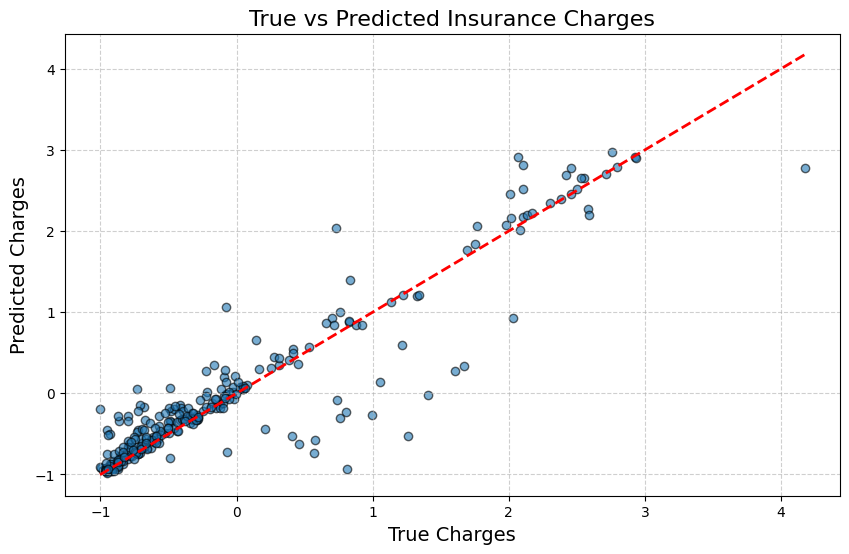

In [26]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_npred, alpha=0.6, edgecolors="k")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=2)
plt.title("True vs Predicted Insurance Charges", fontsize=16)
plt.xlabel("True Charges", fontsize=14)
plt.ylabel("Predicted Charges", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

In [11]:
#Gradient Boosting
gbr_model = GradientBoostingRegressor(random_state=42)

# Define the parameter grid (adjusted for Gradient Boosting)
grid_values = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [1, 5, 10],
    'min_samples_split': [2, 10, 20],
    'random_state': [42]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(
    estimator=gbr_model,
    param_grid=grid_values,
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Optimize for R² score
    verbose=1,
    n_jobs=-1  # Use all available processors
)

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Extract the results
mean_test_scores = grid_search.cv_results_['mean_test_score']
param_combinations = grid_search.cv_results_['params']
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Print the results
print(f"Best Parameters: {best_params}")
print(f"Best R² Score: {best_score:.2f}")

Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Best Parameters: {'learning_rate': 0.01, 'max_depth': 5, 'min_samples_leaf': 10, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 42}
Best R² Score: 0.84


Gradient Boost Test OSR²: 0.87
Gradient Boost Test MSE: 0.13
Gradient Boost Test MAE: 0.21


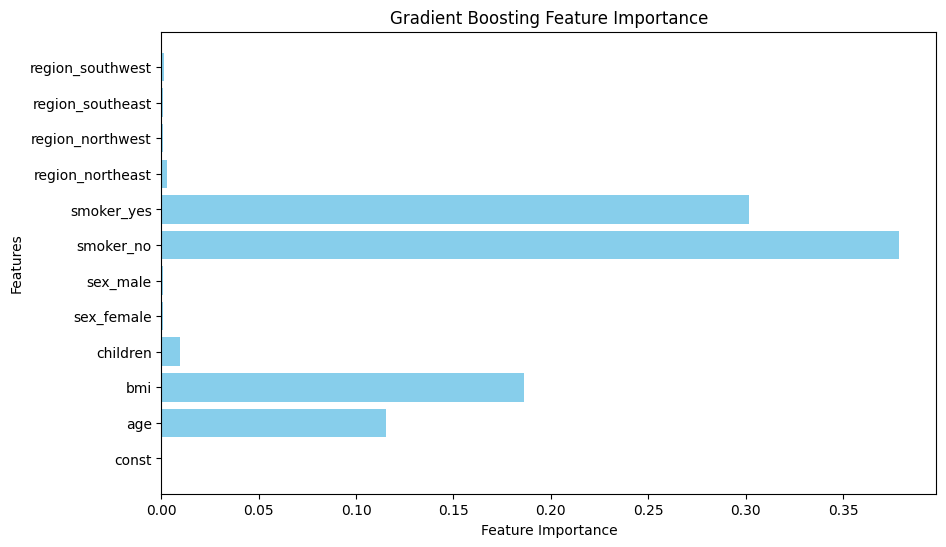

In [12]:
# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# Evaluate on the test set
gb_y_pred = best_model.predict(X_test)
gb_osr2 = r2_score(y_test, gb_y_pred)
gb_mse = mean_squared_error(y_test, gb_y_pred)
gb_mae = mean_absolute_error(y_test, gb_y_pred)

# Print metrics
print(f"Gradient Boost Test OSR²: {gb_osr2:.2f}")
print(f"Gradient Boost Test MSE: {gb_mse:.2f}")
print(f"Gradient Boost Test MAE: {gb_mae:.2f}")

# Feature Importance
feature_importance = best_model.feature_importances_
features = X_train.columns

# Plot Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(features, feature_importance, color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Gradient Boosting Feature Importance')
plt.show()

In [29]:
# Creates a df with the model and our chosen performance metrics

results = {
    'Model': ['Baseline', 'Linear Regression', 'Linear Regression With Feature Selection', 'Random Forest', 'Random Forest With Feature Selection', 'Gradient Boosting', 'CART'],
    'OSR²': [baseline_osr2, linear_all_osr2, linear_select_osr2, rf_r2, rf_selected_osr2, gb_osr2, cart_osr2],
    'MSE': [baseline_mse, linear_all_mse, linear_select_mse, rf_mse, rf_selected_mse, gb_mse, cart_mse],
    'MAE': [baseline_mae, linear_all_mae, linear_select_mae, rf_mae, rf_selected_mae, gb_mae, cart_mae]
}

results_df = pd.DataFrame(results)

results_df.set_index('Model', inplace=True)

results_df['MSE'] = results_df['MSE'].round(6)

print(results_df)

                                              OSR²       MSE       MAE
Model                                                                 
Baseline                                 -0.000919  1.060383  0.792479
Linear Regression                         0.783750  0.229098  0.343515
Linear Regression With Feature Selection  0.155189  0.895001  0.755670
Random Forest                             0.862540  0.145626  0.211237
Random Forest With Feature Selection      0.859342  0.149014  0.208220
Gradient Boosting                         0.874407  0.133054  0.211862
CART                                      0.853057  0.155672  0.236722


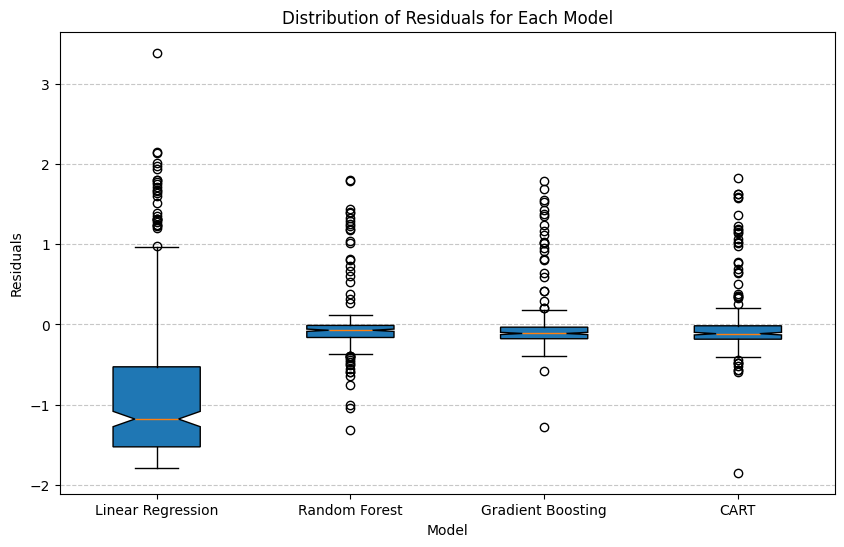

In [30]:
# Creates a box and whisker plot for the distribution of residuals for each model

residuals = {
    'Linear Regression': y_test - linear_all_osr2,
    'Random Forest': y_test - rf_y_pred,
    'Gradient Boosting': y_test - gb_y_pred,
    'CART': y_test - cart_y_pred
}

# Create a box plot for residuals
plt.figure(figsize=(10, 6))
plt.boxplot(residuals.values(), labels=residuals.keys(), patch_artist=True, notch=True)
plt.title('Distribution of Residuals for Each Model')
plt.xlabel('Model')
plt.ylabel('Residuals')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()